# Upload on Colab
Make sure you are on the GPU runtime for this, as it is the only one with sufficient memory. Upload your kaggle.json file to the main directory then run the following snippit. It takes about 20 minutes but accessing the image data on colab is much faster after this takes place.

In [1]:
!rm -rf /root/.kaggle; mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/
!kaggle competitions download -c recursion-cellular-image-classification >/dev/null
!unzip pixel_stats.csv.zip
!rm -rf pixel_stats.csv.zip
!unzip train.csv.zip
!rm -rf train.csv.zip
print("Data Loaded")
!mkdir test
!unzip test.zip -d test >/dev/null
!rm -rf test.zip 
print("Test set unzipped")
!mkdir train
!unzip train.zip -d train >/dev/null
!rm -rf train.zip
print("Train set unzipped")
!git clone https://github.com/recursionpharma/rxrx1-utils
print("fin")


100% 17.6M/17.6M [00:00<00:00, 69.8MB/s]
100% 358k/358k [00:00<00:00, 121MB/s]
100% 561k/561k [00:00<00:00, 79.5MB/s]
100% 112k/112k [00:00<00:00, 113MB/s]
100% 235k/235k [00:00<00:00, 74.9MB/s]
100% 204k/204k [00:00<00:00, 81.9MB/s]
100% 34.8k/34.8k [00:00<00:00, 61.5MB/s]
100% 15.7G/15.7G [02:26<00:00, 115MB/s]
100% 29.9G/29.9G [06:25<00:00, 83.4MB/s]
Archive:  pixel_stats.csv.zip
  inflating: pixel_stats.csv         
Archive:  train.csv.zip
  inflating: train.csv               
Data Loaded
Test set unzipped
Train set unzipped
Cloning into 'rxrx1-utils'...
remote: Enumerating objects: 118, done.
remote: Total 118 (delta 0), reused 0 (delta 0), pack-reused 118
Receiving objects: 100% (118/118), 1.59 MiB | 2.76 MiB/s, done.
Resolving deltas: 100% (59/59), done.
fin


# imports for rest of colab doc

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from multiprocessing import Process, Queue
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K
import random as rand
from scipy import stats
import matplotlib.pyplot as plt
import gc


import pandas as pd
import numpy as np
import os
import sys
from google.colab import files
sys.path.append('/content/rxrx1-utils')

import rxrx.io as rio


Using TensorFlow backend.


# Training Functions
### get_image
By design off how rio.combine_metadata(,...) works, found in rxrx1-utils, this simply takes a input in the form of an array and pulls an image from the current directory. Without loading the data with base_path='./', this function takes multiple times longer from loading from a google drive I beleive located somewhere in the midwest. If you do not downloadthe kaggle info, you can delete this.

### bounded_tuples
First by perfomring a convololution in an individual image, it finds where the image data lies. A 'lack' of cells is where there exists small numbers for each channel, thus by performing a nxnx6 convolution with a vector of ones it finds where the relevant image data lies. It also removes upper extremes after trimming the bottom by finding the mean and only taking data within two standard deviations of the mean. This metadata is stored for training on subsets of images (providing an acceptable bound for which to train a CNN). 

### learning_sets
Simply pass in arrays of experiments seen in the train file, such as "HEPG2-01", as well as a set of sirna's. If val is set to False, it puts the full image data in the train set, otherwise it splits the data to a validation set and a training set. It is a map for each sirna in the set with metadata attached like such:  
{sirnaNum: [{'label': sirnaNum, 'img': [image query data here], 'tuples': [(tuple1), ...], 'mean': m, 'std': s},  
{...}  
...]}... etc



In [0]:
########################################################################################################################################
########################################################################################################################################
########################################################################################################################################
def get_image(query):
  """
  Simply a function that grabs images from the query"""
  assert len(query) == 8, "Not a valid query"
  #                   'dataset' 'exp'     'plate'
  return rio.load_site(query[1], query[2], query[3],
  #                   'well'    'site'
                       query[6], query[5], base_path='./')

########################################################################################################################################
def bounded_tuples(img, dim):
  """
  Bounds the acceptable slices of the image
  """
  #
  def trim_conv(mask_vals):
    top = max(mask_vals)
    bot = min(mask_vals)
    trim = (top - bot)*.05 + bot
    result = [i for i in mask_vals[100:] if i > trim]
    mean = np.mean(result)
    std = np.std(result)
    return mean + 2*std, trim, mean, std
  
  def apply_mask(img, i, j, mask, dim):
    return np.sum(img[i:i+dim[0], j:j+dim[1]]*mask)
  mask = np.ones(dim)
  
  # map mask values to dict
  mask_vals = {}
  m_v = []
  for i in range(0, 512 - dim[0], 4):
    for j in range(0, 512 - dim[1], 4):
      val = apply_mask(img, i, j, mask, dim)
      mask_vals[(i, j)] = val
      m_v.append(val)
  
  
  # bound data by trimming
  top, bot, mean, std = trim_conv(m_v)
  x = list(mask_vals.keys())
  
  # remove bad vals
  for pos in x:
    if mask_vals[pos] < bot or mask_vals[pos] > top:
      del mask_vals[pos]
  l = list(mask_vals.keys())
  temp = set(l[:])
  img_v = []
  while temp:
    i, j = temp.pop()
    img_v.append(np.mean(img[i:i+32, j:j+32]))
    for a in range(i - 32, i + 32):
      for b in range(j - 32, j + 32):
        if (a, b) in temp:
          temp.remove((a, b))
        
  mean = np.mean(img_v)
  std = np.std(img_v)
  
  
  del mask_vals
  result = np.zeros((len(l), 2)).astype(np.uint16)
  for i in range(len(l)):
    result[i] = [l[i][0], l[i][1]]
  return result, mean, std

########################################################################################################################################

def learning_sets(sirna_list, train_sirna, experiment_list, dim, val=True):
  """
  :param dataset: set to test or train, decides the data coming back
  :param sirna_list: a list of sirnas, must be between 0 and 1107 inclusive, of the form [3, 10, 2, ...]
  :param experiment_list: the list of experiments to train on, of the form ['HEPG2-01', ...]
  :param validate: set to True, if False, it uses full dataset
  :return: in order: X_train, y_train, X_test, y_test, from_label (from label is a mapping back to the orignal sirnas)
  """
  dataset = "train"
  assert train_sirna in sirna_list, "validation sets need to have train sirna in list"
  sirna_list = list(sirna_list)
  
  
  # get full table
  md = rio.combine_metadata()
  
  
  # maps of validation sets and train sets
  # will be of form {sirnaID: } 
  validate = {i: [] for i in sirna_list}
  train = {i: [] for i in sirna_list}
    
  # pull the proper query
  train_dat = md\
    .query('dataset == "{}" and sirna == {} and (experiment == {})'
    .format(dataset, sirna_list, experiment_list))\
    .astype({'sirna': np.int32})
  
  # create and remove validation from training set, 
  # otherwise train on full results
  if val:
    # finish off the validation set
    for i in range(len(sirna_list)):
      sirna = sirna_list[i]
      print(sirna)
      # randomize each query section, pull query and remove it from data
      for exp in experiment_list:
        
      
        # this query should be a superkey, thus temp is of size 1
        site = rand.randint(1,2)
        query = 'site == {} and sirna == {} and experiment == "{}"'.format(site, sirna, exp)
        try:
          temp = train_dat.query(query).to_numpy().tolist()[0]
        except:
          print(sirna)
          continue
        

        # remove the item in the query
        train_dat = train_dat.query('not ({})'.format(query))

        # append validate
        tem = {'img': None, 'label': None, 'tuples': None}
        if sirna == train_sirna:
          tem['label'] = sirna
        else:
          tem['label'] = sirna
        tem['img'] = temp
        
        # trim outliers from images
        t = get_image(temp)
        
        tem['tuples'], tem['cellmean'], tem['cellstd'] = bounded_tuples(t, dim)
        tem['imgmean'] = np.mean(t)
        tem['imgstd'] = np.std(t)
        validate[i].append(tem)
        del t
      
  ####################################################################
  
  # finish off the validation set, inialize first
  train_dat = train_dat.to_numpy().tolist()
  print(len(train_dat))
  # after initialization, finish off set
  for j in range(len(train_dat)):
    if j % 100 == 0:
      print(j)
    temp = {'img': None, 'label': None, 'tuples': None}
    i = train_dat[j]
    sirna = i[4]
    if sirna == train_sirna:
      temp['label'] = sirna
    else:
      temp['label'] = sirna
    temp['img'] = i
    t = get_image(i)
    
    # trim outliers from images
    temp['tuples'], temp['cellmean'], temp['cellstd'] = bounded_tuples(t, dim)
    temp['imgmean'] = np.mean(t)
    temp['imgstd'] = np.std(t)
    train[sirna].append(temp)
    del t
  
  return train, validate

########################################################################################################################################
exper = ["HUVEC-01", "HUVEC-02", "HUVEC-03", "HUVEC-04", "HUVEC-05", "HUVEC-06",
         "HUVEC-07", "HUVEC-08", "HUVEC-09", "HUVEC-10", "HUVEC-11", "HUVEC-12",
         "HUVEC-13", "HUVEC-14", "HUVEC-15", "HUVEC-16", "HEPG2-01", "HEPG2-02",
         "HEPG2-03", "HEPG2-04", "HEPG2-05", "HEPG2-06", "HEPG2-07", "U2OS-01", 
         "U2OS-02", "U2OS-03", "RPE-01", "RPE-02", "RPE-03", "RPE-04", "RPE-05",
         "RPE-06", "RPE-07"]
# exper = ["U2OS-01", "U2OS-02", "U2OS-03"]
# exper = ["U2OS-01"]
exper = ["RPE-01", "RPE-02", "RPE-03", "RPE-04", "RPE-05", "RPE-06", "RPE-07"]
d = (32, 32, 6)
sirnas = {i for i in range(8)}
# train, validate = learning_sets(sirnas, 0, exper, d, val=False)

# Visualizing the data
Below is a simple plot of some of the metadata collected. It was the RPE utilized and shown in the plots, the mean and spread of images differ to some degree, slightly clustering them. The second shows the center of each cluster shown with a hollowed out circle. These centeres have clusterings in some areas, but differ in others. This implies some good feature engineering could make a good/better system.

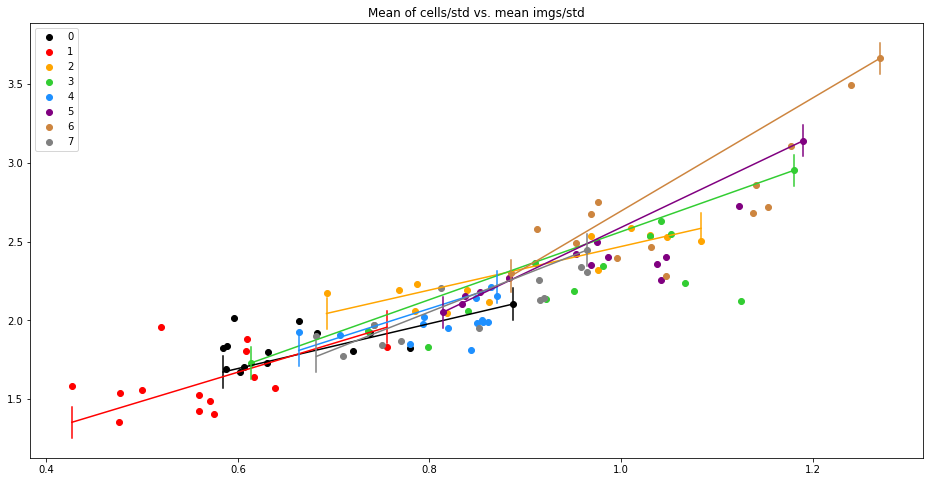

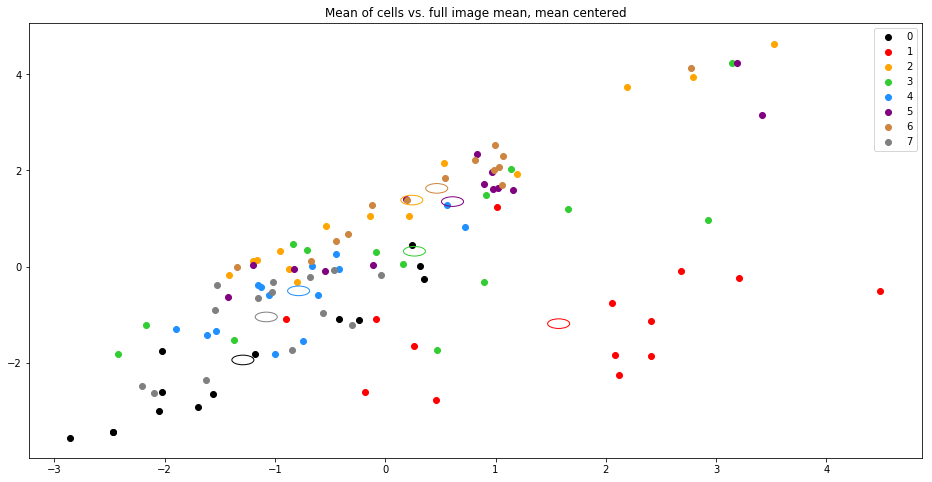

In [5]:
colors = ['black', 'red', 'orange', 'limegreen', 'dodgerblue', 'purple', 'peru', 'grey']
plt.figure(figsize=(16, 8), facecolor='w')
imgmean = []
imgstd = []
cellmean = []
cellstd = []
for j in range(8):
  cmean = []
  cstd = []
  imean = []
  istd = []
  for i in train[j]:
    cm = i['cellmean']
    cs = i['cellstd']
    im = i['imgmean']
    ist= i['imgstd']
    label = i['label']
    
    imgmean.append(im)
    imgstd.append(ist)
    cellmean.append(cm)
    cellstd.append(cs)
    cmean.append(cm / cs)
    cstd.append(im / ist)
  plt.scatter(cstd, cmean, label=label, color=colors[j])
  plt.plot([min(cstd) for i in range(3)], [min(cmean) + (i-1)/10 for i in range(3)], color=colors[j] )
  plt.plot([max(cstd) for i in range(3)], [max(cmean) + (i-1)/10 for i in range(3)], color=colors[j] )
  plt.plot([min(cstd), max(cstd)], [min(cmean), max(cmean)], color=colors[j] )
plt.title("Mean of cells/std vs. mean imgs/std")
plt.legend() 
plt.show()
meani = np.mean(imgmean)
meanc = np.mean(cellmean)

plt.figure(figsize=(16, 8), facecolor='w')
for j in range(8):
  cmean = []
  cstd = []
  imean = []
  istd = []
#   colors = np.random.rand(3,)
  for i in train[j]:
    cm = i['cellmean'] - meanc
    cs = i['cellstd']
    im = i['imgmean'] - meani
    ist= i['imgstd']
    label = i['label']
    
    cmean.append(im)
    cstd.append(cm)
  plt.scatter(cstd, cmean, label=label, color=colors[j])
  circle=plt.Circle((np.mean(cstd), np.mean(cmean)), 1/10, color=colors[j], fill=False)
  plt.gcf().gca().add_artist(circle)
plt.title("Mean of cells vs. full image mean, mean centered")
plt.legend() 
plt.show()

# What to train on
Shown below is an image without any slection. Notice that there is a lot of blackspace, which is not something we would want to train with. With careful selection and using the 'tuples' metadata when creating the training set, the image on bottom shocases what would be selected for training. This also reduces variance (which I figured out after my first model was implemented). 

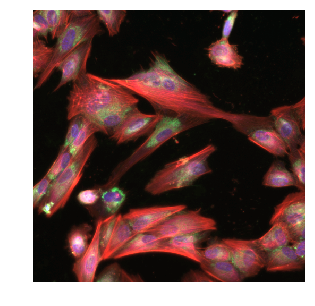

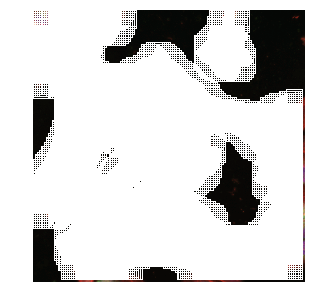

In [6]:
def box(img, i, j, dim):
  """
  Helper for visualizing training set
  """
  img[i:i+dim[0], j:j+2] = 55
  img[i:i+2, j:j+dim[1]] = 55
  img[i+dim[0]-2:i+dim[0], j:j+dim[1]] = 55
  img[i:i+dim[0], j+dim[1]-2:j+dim[1]] = 55
t = get_image(train[0][0]['img'])
x = rio.convert_tensor_to_rgb(t)
plt.figure(figsize=(5, 5))
plt.axis('off')
_ = plt.imshow(x)
for i, j in train[0][0]['tuples']:
  box(t, i, j, d)
x = rio.convert_tensor_to_rgb(t)
plt.figure(figsize=(5, 5))
plt.axis('off')
_ = plt.imshow(x)

# Training Generator / Image Augmentation
This Generator was implemented specifically for training this data. It utilizes threading so it is constantly re-filling each datapool while it trains on the others. Sometimes this is useful, as it cuts training down by minutes even hours in some cases. Since I beleive it can be assumed cell images have no specific orientation, I also randomly transposed, flipped and rotated all the images.

In [0]:
#####################################################################################################################
#####################################################################################################################
#####################################################################################################################
class DataGenerator(keras.utils.Sequence):
    from numpy import flip, transpose
    from random import shuffle, choice, seed, randint

    'Generates data for Keras'
    def __init__(self,
                 sirnas_to_pic,             # A dictionary for each sinra to each unique set of pictures
                 sirnas,                    # The unique set of sirnas
                 dim=32,               # dimention of shape n x n for the images
                 n_channels=6,
                 n_classes=32,
                 batch_size=1024
                 ):

        'Initialization'
        # A few assertions
        assert len(sirnas) == n_classes,        "channels and sirnas must match"

        # since it needs to go from 0 to number of classes to train proper, this mapping will help
        self.train_id_to_sirna = {i: j for i, j in enumerate(sirnas)}
        self.sirna_to_train_id = {j: i for i, j in enumerate(sirnas)}
        

        # There will exist two datafeeds for this gen, one to train on, one to refill with a worker processor
        self.pixels = dim
        self.batch_size = batch_size
        self.dim = (dim, dim, 6)
        temp_dim = (n_classes*batch_size, dim, dim, 6)
        
        # should be twice the size of a single datafeed
        self.batches_per_epoch = n_classes*2
        
        # initialize datafeeds
        self.datafeeds = [np.zeros(temp_dim, dtype='uint8'), np.zeros(temp_dim, dtype='uint8')]
        self.classes = [np.zeros(temp_dim[0]), np.zeros(temp_dim[0])]
        
        # simply do the number of classes per batch
        self.sirnas = sirnas
        self.sirnas_to_pic = sirnas_to_pic
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.__predict = False

        # in the case of prediction, the results of the classification
        # are stored here, and accessed later
        self.class_result = []
        q = Queue()
        self.fill_data(0, q)
        self.datafeeds[0][:], self.classes[0][:] = q.get()
        self.fill_data(1, q)
        self.datafeeds[1][:], self.classes[1][:] = q.get()
        self.generator = self.__data_generation()
        
        
    ##########################################################################################################
    def return_dim(self):
      return self.dim
    
    ##########################################################################################################
    def __len__(self):
        """
        Denotes the number of batches per epoch
        :return: declared in init, self.batches_per_epoch
        """
        return self.batches_per_epoch
    
    ##########################################################################################################
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        return next(self.generator)

    ##########################################################################################################
    def on_epoch_end(self):
        'Only matters if predicting, for returning the results'
        gc.collect()
        
    
    ##########################################################################################################
    def predict(self, p):
        """
        calling determines if the values are stored for classification
        :return: None
        """
        if p:
          self.__predict = True
          self.class_result = []
          return
        self.__predict = False
    
    ##########################################################################################################
    def get_y_true(self):
      return self.class_result

    ##########################################################################################################
    def fill_data(self, pool, queue):
        """
        Initializes data in two batces
        """
        assert pool == 1 or pool == 0, "pool must be one or zero"

        # randomly choose a image for each sirna
        choice_set = [DataGenerator.choice(self.sirnas_to_pic[sirna]) for sirna in self.sirnas] 

        # need the right size per epoch
        
        

        #fill data in place
        for i in range(len(choice_set)):
            key = tuple(choice_set[i]['img'])
            sirna = self.sirna_to_train_id[key[4]]
            img = DataGenerator.get_image(key)
            x = self.sample_image(img, choice_set[i]['tuples'])
            del img
            self.datafeeds[pool][i*self.batch_size:(i+1)*self.batch_size] = x
            self.classes[pool][i*self.batch_size:(i+1)*self.batch_size] = choice_set[i]['label']
        
        # shuffle in place
        from numpy import random as rand
        seed = DataGenerator.randint(0, 10000000)
        rand.seed(seed)
        rand.shuffle(self.datafeeds[pool])
        rand.seed(seed)
        rand.shuffle(self.classes[pool])
        queue.put((self.datafeeds[pool], self.classes[pool]))

    

    ##########################################################################################################
    def sample_image(self, img, tuples):
        """
        """
        
        # initialize numpy matrix and values
        init = np.zeros((self.batch_size, *self.dim),  dtype='uint8')
        
        # finish
        for sample in range(self.batch_size):
            i, j = DataGenerator.choice(tuples)
            temp = DataGenerator.uniform_sampler(img, i, j, p=self.pixels)
            init[sample:(sample + 1)] = DataGenerator.random_transform(temp)
  
        return init.astype('uint8')
  
    ##########################################################################################################
    def __data_generation(self):
        
        # Initialization
        pool = 1

        # Generate data
        while True:
          q = Queue()
          p = Process(target=self.fill_data, args=(1 - pool, q))
          p.start()
          for i in range(self.batches_per_epoch//2):
            X = self.datafeeds[pool][i*self.batch_size:(i + 1)*self.batch_size] 
            y = self.classes[pool][i*self.batch_size:(i + 1)*self.batch_size]
            if self.__predict:
              self.class_result += [self.train_id_to_sirna[j] for j in y]
            result = X.astype("float32") / 200
            result = (result - result.mean(axis=0))
            yield result, keras.utils.to_categorical(y, num_classes=32)
          
          pool = 1 - pool
          self.datafeeds[pool][:], self.classes[pool][:] = q.get()
          q.empty()
          p.join()


    ##########################################################################################################
    @staticmethod
    def random_transform(A):
        """

        :param A: n x n image
        :return: A randomly transformed
        """
        assert A.shape[0] == A.shape[1], "The matrix must be n x n x channels"

        def rotate_90(A):
            A = DataGenerator.flip(A, axis=0)
            return DataGenerator.transpose(A, axes=(1,0,2))

        def horizontal_flip(A):
            A = DataGenerator.transpose(A, axes=(1,0,2))
            A = DataGenerator.flip(A, axis=0)
            return np.transpose(A, axes=(1,0,2))

        def vertical_flip(A):
            return DataGenerator.flip(A, axis=0)

        def transpose_(A):
            return DataGenerator.transpose(A, axes=(1,0,2))

        # randomly add each function
        transforms = [] + [rotate_90] * rand.randint(0, 3)
        transforms += [horizontal_flip] * rand.randint(0, 1)
        transforms += [vertical_flip] * rand.randint(0, 1)
        transforms += [transpose_] * rand.randint(0, 1)
        DataGenerator.shuffle(transforms)

        # twists and turns the matrix
        for i in transforms:
            A = i(A)
        return A

    ##########################################################################################################
    @staticmethod
    def get_image(query):
        assert len(query) == 8, "Not a valid query"
        #                   'dataset' 'exp'     'plate'
        return rio.load_site(query[1], query[2], query[3],
        #                   'well'    'site'
                             query[6], query[5], base_path='./')

    ##########################################################################################################
    @staticmethod
    def uniform_sampler(B, i, j, p=32):
        """
            Given a starting position, i, j, the function wraps around the matrix
        assuming i + p or j + p is greater than n. This sampler is similar to a
        technique used in random forests called bagging, assuming the i and j inputs
        are random
        :param B: input numpy matrix, assuming a photo. Must be shape (n, n, channels)
        :param i: row axis
        :param j: column axis
        :param p: the size of the matrix you want to return (p, p, channels)
        """
        assert B.shape[0] == B.shape[1],    "must be square matrix"
        n = B.shape[0]
        assert i < n and j < n,             "i: {} and j: {} must be less than n: {}".format(i, j, n)
        assert i >= 0 and j >= 0,           "i: {} and j: {} must be greater or equal to 0".format(i, j)
        assert p > 0 and p < n,             "p must be less than n and greather than 0"

        # out of bounds in rows and columns
        if n - i < p and n - j < p:
            top_left = B[i:n, j:n]                          # | top left | right        | right         |
            left = B[0: -n + i + p, j:n]                    # | left     | bottom right | bottom right  |
            right = B[i:n, 0: -n + j + p]                   # | left     | bottom right | bottom right  |
            bottom_right = B[0: -n + i + p, 0: -n + j + p]
            left = np.vstack((top_left, left))
            right = np.vstack((right, bottom_right))
            return np.hstack((left, right))

        # rows out of bounds
        elif n - i < p:
            top = B[i:n, j:j + p]                           # | top     | top       | top       |
            bottom = B[0:p - n + i, j:j + p]                # | bottom  | bottom    | bottom    |
            return np.vstack((top, bottom))                 # | bottom  | bottom    | bottom    |

        # cols out of bounds
        elif n - j < p:
            left = B[i:i + p, j:n]                          # | left    | right     | right     |
            right = B[i:i + p, 0:p - n + j]                 # | left    | right     | right     |
            return np.hstack((left, right))                 # | left    | right     | right     |

        # slice me some matrix pie
        return B[i:i + p, j:j + p]

In [7]:
exper = ["RPE-01", "RPE-02", "RPE-03", "RPE-04", "RPE-05", "RPE-06", "RPE-07"]
d = (32, 32, 6)
sirnas = {i for i in range(32)}
# train, validate = learning_sets(sirnas, 0, exper, d)
trainer = DataGenerator(train, sirnas, dim=32)
verify = DataGenerator(validate, sirnas, dim=32)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
224
0
100
200


In [8]:
print(verify.datafeeds[0].shape)
print(verify.classes[0].shape)
print(verify.return_dim())



(32768, 32, 32, 6)
(32768,)
(32, 32, 6)


In [9]:
model0 = Sequential()

# 1st Convolutional Layer
model0.add(Conv2D(filters=128, input_shape=trainer.return_dim(), kernel_size=(3,3),\
 strides=(1,1), padding='same'))
model0.add(Activation('relu'))
model0.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

# 2nd Convolutional Layer
model0.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model0.add(Activation('relu'))
model0.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model0.add(BatchNormalization())

# 3rd Convolutional layer
model0.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model0.add(Activation('relu'))
model0.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='same'))
model0.add(BatchNormalization())

# First dense
model0.add(Flatten())
model0.add(Dense(256*4, input_shape=trainer.return_dim()))
model0.add(Activation('relu'))
model0.add(Dropout(0.4))

# 2nd Dense Layer
model0.add(Dense(256*4))
model0.add(Activation('relu'))
# Add Dropout
model0.add(Dropout(0.4))
# Batch Normalisation
model0.add(BatchNormalization())

# 3rd Dense Layer
model0.add(Dense(1000))
model0.add(Activation('relu'))
# Add Dropout
model0.add(Dropout(0.4))
# Batch Normalisation
model0.add(BatchNormalization())

model0.add(Dense(32))
model0.add(Activation('softmax'))
model0.summary()

W0724 18:56:02.897947 139642522888064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 18:56:02.927358 139642522888064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0724 18:56:02.931025 139642522888064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0724 18:56:02.953635 139642522888064 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0724 18:56:02.996321 139642522888064 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 128)       7040      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 128)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 256)       0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 256)         1024      
__________

In [0]:
# initiate RMSprop optimizer
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-2)
opt = keras.optimizers.Adam(lr=0.0000001, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)
# Let's train the model using RMSprop
model0.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
# model0.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-2, amsgrad=False),\
#  metrics=['accuracy'])
weights = {i:1 for i in range(32)}
# val_acc = []

Epoch 1/1
64/64 [==============================] - 42s 657ms/step - loss: 2.2863 - acc: 0.3240 - val_loss: 2.5930 - val_acc: 0.2287
0: | 0.28088235294117647 ||| 1: | 0.5252574791564493 ||| 2: | 0.27837051406401553 ||| 3: | 0.19717624148003896 ||| 4: | 0.3547595682041217 ||| 5: | 0.5093046033300686 ||| 6: | 0.32782101167315175 ||| 7: | 0.17047110247693054 ||| 8: | 0.7156142927068038 ||| 9: | 0.15501222493887531 ||| 10: | 0.37247353224254093 ||| 11: | 0.13701330704780681 ||| 12: | 0.14572127139364302 ||| 13: | 0.20906432748538012 ||| 14: | 0.4864864864864865 ||| 15: | 0.2690453230472517 ||| 16: | 0.17442430181283686 ||| 17: | 0.25617433414043583 ||| 18: | 0.07190795781399809 ||| 19: | 0.17966436327739388 ||| 20: | 0.25073170731707317 ||| 21: | 0.3979591836734694 ||| 22: | 0.24660852713178294 ||| 23: | 0.22920696324951645 ||| 24: | 0.13787954206072672 ||| 25: | 0.28507462686567164 ||| 26: | 0.4833822091886608 ||| 27: | 0.3012757605495584 ||| 28: | 0.1696733300828864 ||| 29: | 0.3440276406

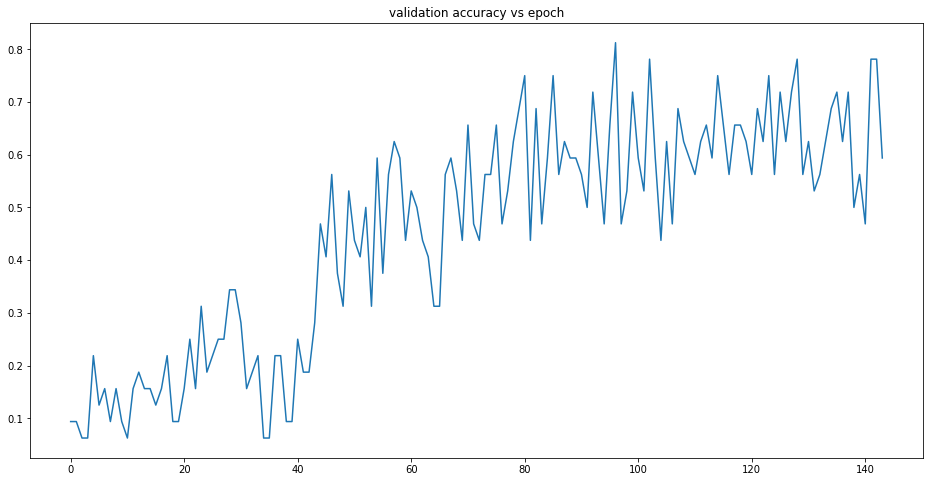

In [37]:
# Fit the model on the batches
for i in range(2):
  verify.predict(False)
  trainer.predict(False)

  model0.fit_generator(trainer,
                      validation_data = verify,
                      epochs=i+1,
                      initial_epoch=i,
                      class_weight=weights,
                      verbose=1
                      #steps_per_epoch=
                      )
  verify.predict(True)
  verify.predict(True)
  predict = model0.predict_generator(verify, verbose=0)
  mam = predict.tolist()

  y = [i for i in verify.get_y_true()]
  test = [[0 for i in range(32)] for j in range(32)]
  for i in range(len(mam)):
    actual = y[i]
    vote = mam[i].index(max(mam[i]))
    test[actual][vote] += 1
  for i in test:
    total = sum(i)
    for j in range(len(i)):
      i[j] /= total
  wins = 0
  
  for i in range(len(test)):
    print('{}:'.format(i), '|', test[i][i], end = ' ||| ')
  print()

  for i in range(len(test)):
    l = test[i]
    temp = []
    for j, k in enumerate(l):
      temp.append((j, k))
    temp.sort(key=lambda x: -x[1])

    if temp[0][0] == i:
      wins += 1
  #print("val_acc:", wins/32)
  val_acc.append(wins/32)

plt.figure(figsize=(16, 8), facecolor='w')
plt.plot(val_acc)
plt.title("validation accuracy vs epoch")
plt.show()

In [41]:
verify.predict(True)
trainer.predict(True)
predict = model0.predict_generator(verify, verbose=1, steps=64*5)
print(predict.shape)
predict2 = model0.predict_generator(trainer, verbose=1, steps=64*5)
predict2.shape

320/320 [==============================] - 71s 222ms/step
(327680, 32)
320/320 [==============================] - 71s 221ms/step


(327680, 32)

In [42]:
mam = predict.tolist()

y = [i for i in verify.get_y_true() ]
print(len(mam), len(y))
test = [[0 for i in range(32)] for j in range(32)]
for i in range(len(y)):
  actual = y[i]
  vote = mam[i].index(max(mam[i]))
  test[actual][vote] += 1 
wins = 0

print(*test, sep=',\n')
for i in range(len(test)):
  l = test[i]
  print(l[i])
  print('cell {}'.format(i))
  temp = []
  for j, k in enumerate(l):
    temp.append((j, k))
  temp.sort(key=lambda x: -x[1])
  if temp[0][0] == i:
    wins += 1
  print(temp)
print(wins/32)

327680 327680
[1537, 112, 53, 53, 561, 153, 41, 968, 24, 225, 124, 20, 56, 441, 276, 96, 494, 104, 689, 104, 689, 556, 18, 242, 462, 1067, 1, 695, 77, 65, 112, 125],
[201, 3629, 68, 412, 204, 700, 788, 58, 434, 7, 1140, 0, 0, 141, 25, 37, 85, 5, 181, 147, 369, 440, 22, 28, 505, 136, 106, 208, 11, 74, 25, 52],
[309, 10, 1156, 7, 60, 8, 9, 195, 0, 344, 11, 246, 149, 111, 1079, 262, 123, 422, 484, 499, 683, 50, 437, 346, 103, 227, 43, 901, 335, 19, 358, 1234],
[147, 350, 248, 1592, 220, 559, 681, 180, 724, 41, 1612, 317, 46, 172, 15, 15, 106, 169, 19, 77, 541, 275, 150, 49, 82, 453, 512, 42, 378, 56, 162, 242],
[789, 74, 24, 34, 2452, 306, 148, 317, 48, 500, 83, 160, 62, 60, 396, 107, 225, 387, 324, 76, 191, 1357, 4, 7, 471, 866, 28, 167, 99, 117, 326, 44],
[41, 207, 100, 555, 256, 2002, 1285, 112, 623, 230, 2030, 484, 14, 31, 47, 16, 175, 13, 97, 47, 79, 230, 147, 70, 281, 80, 285, 61, 94, 215, 96, 238],
[37, 162, 326, 243, 100, 921, 2747, 129, 673, 66, 919, 262, 27, 81, 45, 33, 49, 51, 

In [43]:
mam = predict2.tolist()
y = [i for i in trainer.get_y_true() ]
print(len(mam), len(y))
trainm = [[0 for i in range(32)] for j in range(32)]
for i in range(len(mam)):
  actual = y[i]
  vote = mam[i].index(max(mam[i]))
  trainm[actual][vote] += 1 
wins = 0

print(*trainm, sep=',\n')
for i in range(len(trainm)):
  l = trainm[i]
  print(l[i])
  print('cell {}'.format(i))
  temp = []
  for j, k in enumerate(l):
    temp.append((j, k))
  temp.sort(key=lambda x: -x[1])
  if temp[0][0] == i:
    wins += 1
  print(temp)
print(wins/32)

327680 327680
[3274, 573, 29, 44, 363, 48, 40, 238, 29, 295, 215, 2, 142, 1496, 261, 267, 448, 10, 543, 17, 395, 374, 2, 129, 103, 413, 3, 351, 14, 27, 61, 66],
[852, 3149, 34, 170, 519, 752, 556, 182, 380, 1, 562, 31, 4, 232, 55, 48, 65, 51, 118, 22, 253, 496, 7, 9, 682, 400, 36, 443, 4, 13, 81, 45],
[214, 71, 3907, 72, 15, 364, 920, 24, 134, 221, 310, 71, 3, 201, 84, 37, 42, 263, 6, 205, 269, 83, 30, 9, 177, 148, 439, 460, 280, 0, 30, 1161],
[85, 261, 503, 2741, 178, 1011, 394, 50, 585, 137, 1002, 184, 23, 64, 14, 58, 17, 33, 43, 21, 144, 165, 106, 18, 157, 268, 1547, 17, 34, 111, 16, 256],
[508, 119, 124, 65, 2159, 215, 36, 205, 111, 401, 155, 26, 187, 24, 324, 345, 312, 192, 490, 22, 291, 1622, 29, 181, 795, 342, 62, 187, 12, 372, 245, 103],
[58, 225, 147, 587, 277, 2872, 1135, 154, 677, 12, 905, 123, 18, 71, 82, 4, 45, 170, 22, 64, 250, 417, 154, 24, 319, 96, 337, 153, 172, 148, 155, 332],
[20, 114, 698, 76, 39, 867, 2922, 50, 691, 78, 1018, 218, 41, 55, 58, 26, 46, 83, 21, 92, 83

In [0]:
def create_normal_matrix(vote_matrix, damp=0, normalize=False):
  # copy the matrix
  v = [[i for i in j] for j in vote_matrix]
  # dampn the
  for i in range(len(v)):
    v[i][i] *= (1-damp)
  if not normalize:
    return v
  from math import sqrt
  for i in range(32):
    temp = sqrt(sum([j**2 for j in v[i]]))
    for j in range(32):
      v[i][j] /= temp
  return v


In [47]:
vote_matrix = create_normal_matrix(test, normalize = False)
train_matrix = create_normal_matrix(trainm, damp=0.2, normalize =False) 
def norm(a, b):
  from math import sqrt
  result = 0
  for i in range(len(a)):
    result += (a[i] - b[i])**2/len(a)
  return result
# for i in range(len(vote_matrix)):
#   temp1 = vote_matrix[i]
#   m1 = max(temp1)//2
#   for j in range(len(temp1)):
#     temp1[j] -= m1
# print(*vote_matrix, sep=',\n')

voters = [-1 for i in range(len(vote_matrix))]
for i in range(len(vote_matrix)):
  ith_voter = vote_matrix[i]
  min_vote = 9999999999999
  idx = 0
  for bin_ in range(len(train_matrix)):
    vote_bin = train_matrix[bin_]
    temp = norm(ith_voter, vote_bin)
    #print(temp, i, bin_)

    if temp < min_vote:
      idx = bin_
      min_vote = temp
  voters[i] = idx
for i in range(len(voters)):
  print(i, voters[i])

0 7
1 1
2 14
3 3
4 4
5 10
6 6
7 20
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 14
31 31


In [48]:
vote_matrix = create_normal_matrix(test, damp=0, normalize = False)
train_matrix = create_normal_matrix(trainm, damp=0.3, normalize = False) 
minu = .0
def norm(a, b):
  from math import sqrt
  result = 0
  for i in range(len(a)):
    result += ((a[i] - 0) * (b[i] - minu))
  return result

for i in range(len(vote_matrix)):
  temp1 = vote_matrix[i]
  temp2 = train_matrix[i]
  m1 = max(temp1)/10
  m2 = max(temp2)/10
  for j in range(len(temp1)):
    pass
    temp1[j] -= m1
    temp2[j] -= m2
# print(*vote_matrix, sep=',\n')
    

voters = [-1 for i in range(len(vote_matrix))]
for i in range(len(vote_matrix)):
  ith_voter = vote_matrix[i]
  min_vote = -10*100000
  idx = -1
  for bin_ in range(len(train_matrix)):
    vote_bin = train_matrix[bin_]
    temp = norm(ith_voter, vote_bin)
    #print(temp, i, bin_)

    if temp > min_vote:
      idx = bin_
      min_vote = temp
  voters[i] = idx
for i in range(len(voters)):
  print(i, voters[i])

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 20
8 8
9 9
10 8
11 11
12 12
13 13
14 12
15 15
16 16
17 17
18 18
19 20
20 20
21 21
22 22
23 23
24 24
25 25
26 26
27 27
28 28
29 29
30 12
31 31
